before executing this notebook, execute the following script to have all the data `.\shell_scripts\entropy_study.ps1`

In [1]:
# preparation of the environment
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm
from torch_set_up import DEVICE
from training_bert import BertNliLight
from regularize_training_bert import SNLIDataModule

### The metrics

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from attention_algorithms.inference_metrics import *

### Special Render for the Metrics

In [3]:
from attention_algorithms.plausibility_visu import hightlight_txt # function to highlight the text
from attention_algorithms.attention_metrics import normalize_attention
from IPython.display import display, HTML

def html_render(model_outputs):
    html = ''

    table_len = len(model_outputs['all_layers']['AUC'])
    for i in range(table_len):
        html += '<table>'
        html += '<tr><th></th>' # One xtra head for model's name
        for column_name in model_outputs['all_layers'].keys():
            html+= '<th>'+ column_name +'</th>'
        html += ' </tr>'
        for name, model_content in model_outputs.items():
            html += '<tr>'
            html += '<td><b>' + name + '</b></td>'

            for k, output in model_content.items():
                displ = output[i] if output is not None else 'N/A'
                if isinstance(displ, float):
                    displ = str(round(displ, 3))
                html += '<td>' + displ + '</td>'

            html += '</tr>'

        html += '</table>'
    return html

### Create the figure to sum up all the metrics

In [4]:
%%capture
fig, axes = plt.subplots(9, 1, figsize = (6, 40))
plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.8)

# set the limits for the axes
y_lims = [(0.5, 1), (-0.01, 0.3), (-0.01, 0.7) ,(-0.01, 1.01), (-0.01, 0.5), (-0.01, 1.01), (-0.01,0.5), (-0.01,1), (-0.01,1)]
for i in range(axes.shape[0]):
        axes[i].set_ylim(y_lims[i][0], y_lims[i][1])

### Regu for the layers 4 to 10

In [5]:
muls = ["mul=0.0", "modif_mul=0.001"]

In [6]:
# load the data
import pickle
d = os.path.join(".cache", "plots", "regu_study", "layer_4_10")

# loading the data
a_hat = {}
for mul in muls:
    with open(os.path.join(d, mul, "a_true_head_mean.pickle"), "rb") as f:
        a_true = pickle.load(f)
    with open(os.path.join(d, mul, "layers_4_10_head_mean.pickle"), "rb") as f:
        layers_4_10 = pickle.load(f)
        a_hat[mul] = layers_4_10.copy()
        
a_ones = {}
a_zeros = {}

for k in ["entailement", "neutral", "contradiction"]:
    a_ones[k] = np.array([1.0] * len(a_true[k]))
    a_zeros[k] = np.array([0.0] * len(a_true[k]))

In [7]:
%%capture
temp = {}
for k in ["entailement", "neutral", "contradiction"]:
    metric_output = {}
    it = 0
    for mul in muls:
        metric_output[mul] = {
                "AUC": [roc_auc_score(a_true[k],a_hat[mul][k])],
                "Jaccard": [scalar_jaccard(a_true[k], a_hat[mul][k])],
                "AUPRC" : [average_precision_score(a_true[k], a_hat[mul][k])],
                "AU - Precision" : [au_precision_curve(a_true[k], a_hat[mul][k])],
                "AU - Recall" : [au_recall_curve(a_true[k], a_hat[mul][k])],
                "Precision (tr)": [precision(a_true[k], a_hat[mul][k])],
                "Recall (tr)": [recall(a_true[k], a_hat[mul][k])],
                "H" : a_hat[mul]["entropy"][k],
                "H-m" : a_hat[mul]["modif_entropy"][k]
        }

    temp[k] = metric_output.copy()
    

In [8]:
%%capture
# complete the graphs
metrics = list(temp["entailement"]["mul=0.0"].keys())

# set the titles
cols = ["Regu Study"]
rows = metrics.copy()

for ax, col in zip([axes[0]], cols):
    ax.set_title(col)

for ax, row in zip(axes[:], rows):
    ax.set_ylabel(row, rotation=60, fontsize=15, labelpad=20)

for id_m, m in enumerate(metrics):
    ax = axes[id_m]
    for label in ["entailement", "neutral", "contradiction"]:
        buff = []
        for agreg in temp[label]:
            buff.append(temp[label][agreg][m][0])
            
        x = list(range(1, len(buff)+1))
        ax.scatter(x, buff, label=label)
        ax.set_xticks(x)
        ax.set_xticklabels(list(temp[label].keys()),fontsize = 15, rotation=80)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 5})
        

plt.legend()

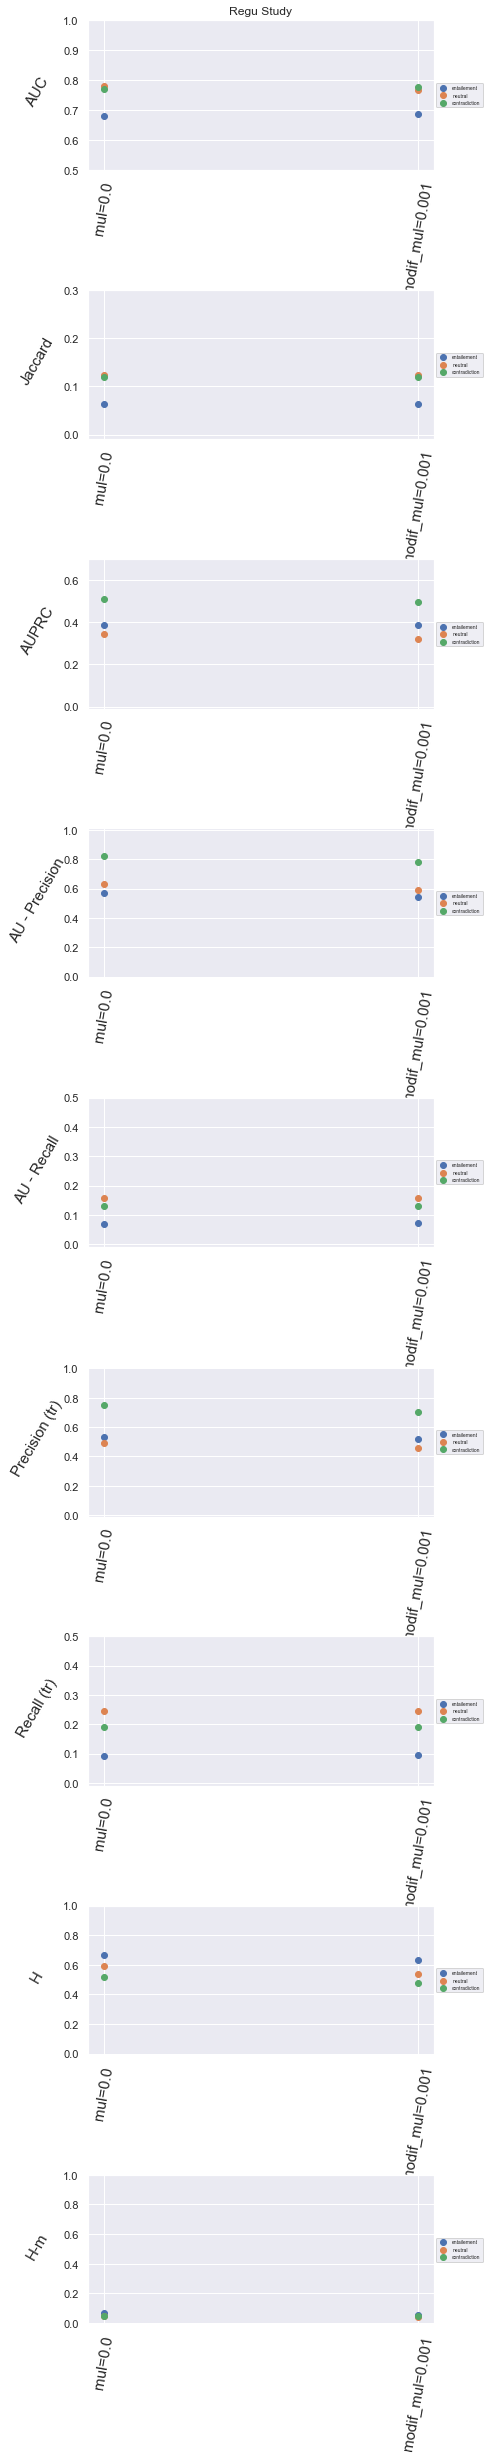

In [9]:
fig

In [10]:
fig.savefig(os.path.join(os.getcwd(),".cache", "plots", "regu_study", "layer_4_10", "modif_metric_graphs.png"))